In [1]:
# Dependencies
import tweepy
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import sem, ttest_ind

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
fit_file = "datasets/fit_tweets.csv"
norm_file = "datasets/norm_tweets1.csv"

fit_tweets = pd.read_csv(fit_file, encoding='utf-8')
norm_tweets = pd.read_csv(norm_file, encoding='utf-8')
fit_tweets = fit_tweets.dropna()
norm_tweets = norm_tweets.dropna()
if len(fit_tweets) < len(norm_tweets):
    norm_tweets = norm_tweets.sample(n=len(fit_tweets))
else:
    fit_tweets = fit_tweets.sample(n=len(norm_tweets))


In [3]:
norm_acct_groups = norm_tweets.groupby('Account')
norm_mean_sents = (norm_acct_groups['Compound'].mean()).tolist()
norm_mean_poss = (norm_acct_groups['Positive'].mean()).tolist()
norm_mean_neus = (norm_acct_groups['Neutral'].mean()).tolist()
norm_mean_negs = (norm_acct_groups['Negative'].mean()).tolist()

fit_acct_groups = fit_tweets.groupby('Account')
fit_mean_sents = (fit_acct_groups['Compound'].mean()).tolist()
fit_mean_poss = (fit_acct_groups['Positive'].mean()).tolist()
fit_mean_neus = (fit_acct_groups['Neutral'].mean()).tolist()
fit_mean_negs = (fit_acct_groups['Negative'].mean()).tolist()

sent_comparison = pd.DataFrame({
    'Fitness User':[np.nanmean(fit_mean_sents),np.nanmean(fit_mean_poss),np.nanmean(fit_mean_negs),np.nanmean(fit_mean_neus)],
    'Normal User':[np.nanmean(norm_mean_sents),np.nanmean(norm_mean_poss),np.nanmean(norm_mean_negs),np.nanmean(norm_mean_neus)],
    'Value':['Compound','Positive','Negative','Neutral']
})
sent_comparison = sent_comparison.set_index("Value") 
sent_comparison.to_csv('sent_comparison.csv',encoding='utf-8')
sent_comparison   


,Fitness User,Normal User
Value,,
Compound,0.182979,0.106118
Positive,0.116532,0.104538
Negative,0.032617,0.054016
Neutral,0.850749,0.841446


In [4]:
sented_n_tweets = norm_tweets.loc[norm_tweets['Compound']!=0]
sented_f_tweets = fit_tweets.loc[fit_tweets['Compound']!=0]

norm_acct_groups = sented_n_tweets.groupby('Account')
norm_mean_sents = (norm_acct_groups['Compound'].mean()).tolist()
norm_mean_poss = (norm_acct_groups['Positive'].mean()).tolist()
norm_mean_neus = (norm_acct_groups['Neutral'].mean()).tolist()
norm_mean_negs = (norm_acct_groups['Negative'].mean()).tolist()

fit_acct_groups = sented_f_tweets.groupby('Account')
fit_mean_sents = (fit_acct_groups['Compound'].mean()).tolist()
fit_mean_poss = (fit_acct_groups['Positive'].mean()).tolist()
fit_mean_neus = (fit_acct_groups['Neutral'].mean()).tolist()
fit_mean_negs = (fit_acct_groups['Negative'].mean()).tolist()

sented_comparison = pd.DataFrame({
    'Fitness User':[np.nanmean(fit_mean_sents),np.nanmean(fit_mean_poss),np.nanmean(fit_mean_negs),np.nanmean(fit_mean_neus)],
    'Normal User':[np.nanmean(norm_mean_sents),np.nanmean(norm_mean_poss),np.nanmean(norm_mean_negs),np.nanmean(norm_mean_neus)],
    'Value':['Compound','Positive','Negative','Neutral']
})
sented_comparison = sented_comparison.set_index("Value") 
sented_comparison.to_csv('sent_comparison_drop_neu.csv',encoding='utf-8')
sented_comparison

,Fitness User,Normal User
Value,,
Compound,0.316328,0.187375
Positive,0.206695,0.184647
Negative,0.057690,0.094314
Neutral,0.735615,0.721038


In [5]:
probs = []
t_vals = []
sented_n_groups = sented_n_tweets.groupby('Account')
norm_mean_sents = (sented_n_groups['Compound'].mean()).tolist()
sented_f_groups = sented_f_tweets.groupby('Account')
fit_mean_sents = (sented_f_groups['Compound'].mean()).tolist()
(ttest,p) = ttest_ind(norm_mean_sents,fit_mean_sents,equal_var=True)
probs.append(p)
t_vals.append(ttest)

neu_n_groups = norm_tweets.groupby('Account')
neu_n_sents = (neu_n_groups['Compound'].mean()).tolist()
neu_f_groups = fit_tweets.groupby('Account')
neu_f_sents = (neu_f_groups['Compound'].mean()).tolist()
(ttest,p) = ttest_ind(neu_n_sents,neu_f_sents,equal_var=True)
probs.append(p)
t_vals.append(ttest)

ttest_summ = pd.DataFrame({
    'Neutrals':['N','Y'],
    'T-Score':t_vals,
    'P-Value':probs,
    'Mean Fitness Sent':[sented_comparison.iloc[0,0],sent_comparison.iloc[0,0]],
    'Mean Normal Sent':[sented_comparison.iloc[0,1],sent_comparison.iloc[0,1]]
})

ttest_summ = ttest_summ.set_index('Neutrals')
ttest_summ.to_csv('ttest_summary.csv')
ttest_summ




,Mean Fitness Sent,Mean Normal Sent,P-Value,T-Score
Neutrals,,,,
N,0.316328,0.187375,1.022844e-17,-8.739792
Y,0.182979,0.106118,3.307267e-16,-8.303089


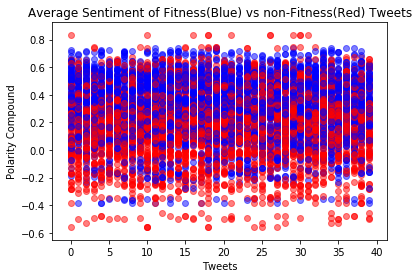

In [6]:
fig,ax = plt.subplots()
x_axis = np.arange(0,40)
for x in range(100):
    norm_sample = random.sample(norm_mean_sents,40)
    fit_sample = random.sample(fit_mean_sents,40)
    ax.scatter(x_axis, norm_sample, color='red',alpha=.5,label='Normal Users')
    ax.scatter(x_axis, fit_sample, color='blue',alpha=.5,label='Fitness Users')
    
plt.xlabel("Tweets")
plt.ylabel("Polarity Compound")
plt.title("Average Sentiment of Fitness(Blue) vs non-Fitness(Red) Tweets")
plt.savefig('user_summary_scatter.png')
plt.show()

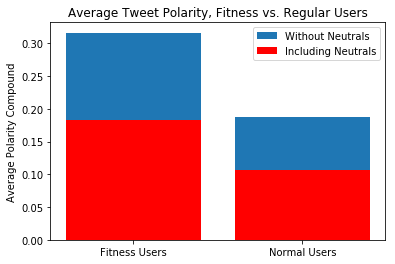

In [7]:
x_axis = np.arange(2)
tick_labels = ['Fitness Users','Normal Users']
fig,ax = plt.subplots()
ax.bar(x_axis,sented_comparison.iloc[0,:],label='Without Neutrals')
ax.bar(x_axis,sent_comparison.iloc[0,:],color='red',label='Including Neutrals')
plt.xticks(x_axis,tick_labels)
plt.ylabel('Average Polarity Compound')
plt.title('Average Tweet Polarity, Fitness vs. Regular Users')
plt.legend()
plt.savefig('user_summary_bar.png')
plt.show()

